In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_validate,RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve

from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced 

import xgboost as xgb

#import shap

X_train=pd.read_csv("X_train_scaled.csv") 
X_test=pd.read_csv("X_test_scaled.csv") 

y_train=pd.read_csv("y_train.csv") 
y_test=pd.read_csv("y_test.csv") 

X_train.head(1)

,Cloud9am,Cloud3pm,WindGustDir_sin,WindGustDir_cos,WindDir9am_sin,WindDir9am_cos,WindDir3pm_sin,WindDir3pm_cos,month_sin,month_cos,...,Pressure3pm,Humidity9am,Humidity3pm,Lat,Lon,AAAA,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Rainfall
0,0.00,7.00,-0.92,0.38,-0.38,0.92,-0.92,0.38,-0.87,-0.50,...,-1.86,0.29,0.15,0.41,0.72,0.20,1.82,1.08,1.09,0.00


In [45]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape) 
print(y_test.shape)

(99374, 25)
(24844, 25)
(99374, 1)
(24844, 1)


## TEST STAT

# TYPE VARIABLES et choix d'encodage--> avis de Florent? ok sur ce qui a été droppé? (raintoday, weekday,evap,sunshine)

RainTommorrow : Binaire -> encodage avant split

Continue : 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am','Humidity9am', 'Humidity3pm', 'Pressure9am','WindSpeed3pm', 'Temp9am', 'Temp3pm','Pressure3pm', "AAAA" ==> minmaxscaler, standardscaler, robustscaler

Catégorielle :
> Cyclique  : 'WindGustDir','WindDir9am', 'WindDir3pm', "MM" -> deja traité
> Nominale : Location, pour de l'encoding ohe, il y a bcp de modalités -> autre encoder nominale, 
sinon utiliser Lat/Lon? et les scaler en minmax?
sinon DistrictRainfall?

  'Cloud9am', 'Cloud3pm', : 0 à 8 ordinale, et 9 caridinale?
Que 

TEST STAT
Pearson : linéaire quanti continue/quanti continue
Spearman : non linéaire quanti continue/quanti continue

ANOVA : continues/quali : ou var cible est continue?

khi2 + vcramer : quali/quali

Reg log

Lien Rainfall, Humidity, Direction du vent


### FEATURE SELECTION (avt et après train/test/split?)
Filter méthod
- Variance Threshold : au regard de la distribution donnée lors de l'EDA : pas utile'

<BarContainer object of 25 artists>

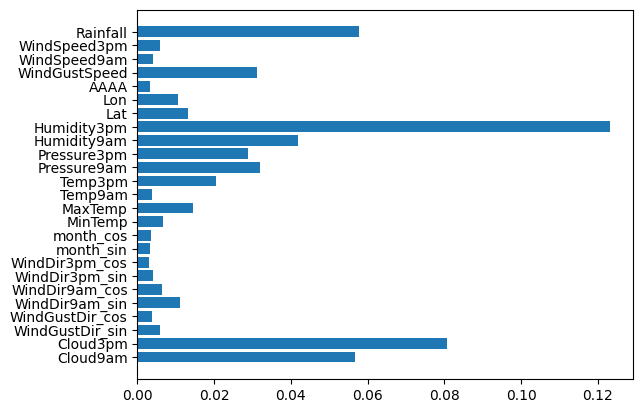

In [3]:

importances = mutual_info_classif(X_train,y_train)
plt.barh(X_train.columns, importances)

In [4]:
X_train = X_train.drop(["AAAA","MaxTemp","MinTemp"], axis=1)
X_test = X_test.drop(["AAAA","MaxTemp","MinTemp"], axis=1)

MODEL

In [50]:
### Fonctions : prédictions de seuil de classification, présentation des résultats
def predictions_seuil_optimal(model,X_test,y_test): 
    # Prédictions probabilistes
    y_proba = model.predict_proba(X_test)[:, 1]

    # Recherche du seuil optimal pour le F1 Score
    seuils = np.arange(0.1, 0.9, 0.01)
    best_thresh, best_f1 = 0.5, 0

    for seuil in seuils:
        temp_pred = (y_proba >= seuil).astype(int)
        score = f1_score(y_test, temp_pred)
        if score > best_f1:
            best_f1 = score
            best_thresh = seuil

    print(f"Seuil optimal : {best_thresh:.2f} | F1 Score : {best_f1:.4f}")

    # Prédiction finale
    y_pred = (y_proba >= best_thresh).astype(int) 

    return y_pred, y_proba


def evaluation(nom_model, y_test, y_pred, y_proba):
    # Rapport de classification
    print("\nRapport de classification :")
    cm = classification_report(y_test, y_pred)
    print(cm)

    # Rapport de classification (imbalanced de imblearn)
    print("\nRapport de classification :")
    print(classification_report_imbalanced(y_test, y_pred))

    # Calcul du F1 score de la classe positive
    f1_positive = f1_score(y_test, y_pred, pos_label=1)
    

    # Création de la figure avec deux sous-graphiques côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[0], cmap="Blues", values_format="d", colorbar=False)
    axes[0].set_title("Matrice de Confusion")
    
    # AUC
    roc_auc = roc_auc_score(y_test, y_proba)
    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color="darkorange")
    axes[1].plot([0, 1], [0, 1], linestyle='--', color="gray")
    axes[1].set_xlabel("Taux de faux positifs")
    axes[1].set_ylabel("Taux de vrais positifs")
    axes[1].set_title("Courbe ROC")
    axes[1].legend()
    axes[1].grid(True)

    # Titre principal et sous-titre
    fig.suptitle(f"Évaluation du modèle : {nom_model}", fontsize=14)
    fig.text(
        0.5,         # x (milieu de la figure)
        0.88,        # y (juste sous le suptitle)
        f"F1-score (classe positive) : {f1_positive:.3f}",
        ha='center', # alignement horizontal centré
        fontsize=12
    )
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [6]:
stop

NameError: name 'stop' is not defined

In [48]:
#Undersampling : réduira au passage la taille du df. 
# à mettre dans une crossvalidation externe?
resample = RandomUnderSampler(sampling_strategy='majority') #majority : QUE la classe majoritaire
print(y_train.value_counts())
# Appliquer la méthode de rééchantillonnage sur l'ensemble d'entraînement
X_train_resampling, y_train_resampling = resample.fit_resample(X_train, y_train)
print(y_train_resampling.value_counts())


RainTomorrow
0               77300
1               22074
Name: count, dtype: int64
RainTomorrow
0               22074
1               22074
Name: count, dtype: int64


Seuil optimal : 0.62 | F1 Score : 0.6496

Rapport de classification :
              precision    recall  f1-score   support

           0       0.91      0.87      0.89     19325
           1       0.61      0.69      0.65      5519

    accuracy                           0.83     24844
   macro avg       0.76      0.78      0.77     24844
weighted avg       0.84      0.83      0.84     24844


Rapport de classification :
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.87      0.69      0.89      0.78      0.62     19325
          1       0.61      0.69      0.87      0.65      0.78      0.59      5519

avg / total       0.84      0.83      0.73      0.84      0.78      0.61     24844



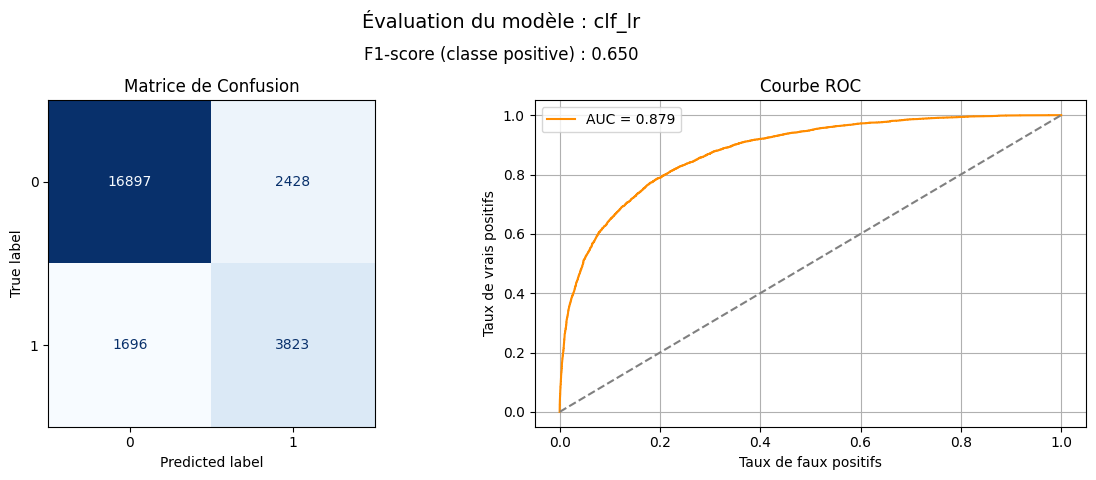

estimateur:{Best params}, scores_f_fold, best_score_f1, Accuracy
{'random_search': ['clf_lr', {'solver': 'newton-cholesky', 'class_weight': None, 'C': 10}, array([0.785, 0.791, 0.791, 0.787, 0.791]), np.float64(0.791), np.float64(0.834)]}
Seuil optimal : 0.61 | F1 Score : 0.6751

Rapport de classification :
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     19325
           1       0.65      0.71      0.68      5519

    accuracy                           0.85     24844
   macro avg       0.78      0.80      0.79     24844
weighted avg       0.85      0.85      0.85     24844


Rapport de classification :
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.89      0.71      0.90      0.79      0.64     19325
          1       0.65      0.71      0.89      0.68      0.79      0.62      5519

avg / total       0.85      0.85      0.75      0.85      0.79      0.64     24844



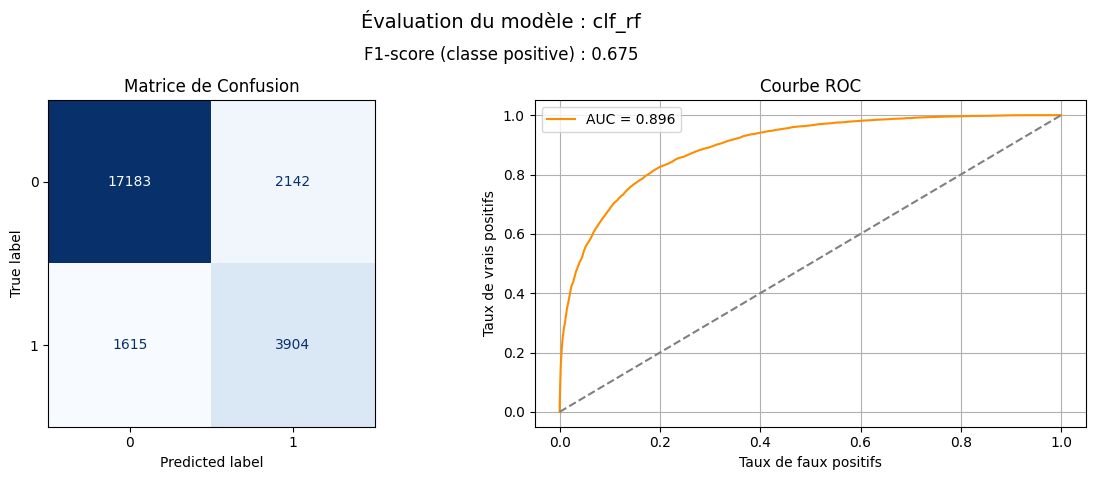

estimateur:{Best params}, scores_f_fold, best_score_f1, Accuracy
{'random_search': ['clf_rf', {'random_state': 0, 'n_jobs': -2, 'n_estimators': 250}, array([0.799, 0.801, 0.807, 0.805, 0.807]), np.float64(0.807), np.float64(0.849)]}
Seuil optimal : 0.62 | F1 Score : 0.6258

Rapport de classification :
              precision    recall  f1-score   support

           0       0.91      0.85      0.88     19325
           1       0.57      0.69      0.63      5519

    accuracy                           0.82     24844
   macro avg       0.74      0.77      0.75     24844
weighted avg       0.83      0.82      0.82     24844


Rapport de classification :
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.85      0.69      0.88      0.77      0.60     19325
          1       0.57      0.69      0.85      0.63      0.77      0.58      5519

avg / total       0.83      0.82      0.73      0.82      0.77      0.60     24844



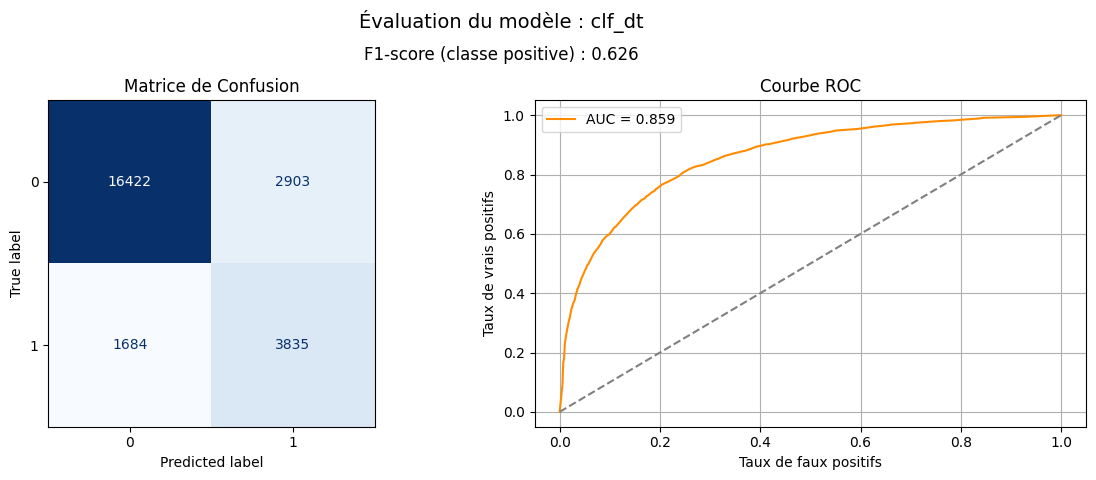

estimateur:{Best params}, scores_f_fold, best_score_f1, Accuracy
{'random_search': ['clf_dt', {'random_state': 0, 'max_depth': 8, 'criterion': 'entropy'}, array([0.773, 0.765, 0.773]), np.float64(0.773), np.float64(0.815)]}
Seuil optimal : 0.56 | F1 Score : 0.6023

Rapport de classification :
              precision    recall  f1-score   support

           0       0.90      0.84      0.87     19325
           1       0.55      0.67      0.60      5519

    accuracy                           0.80     24844
   macro avg       0.72      0.76      0.74     24844
weighted avg       0.82      0.80      0.81     24844


Rapport de classification :
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.84      0.67      0.87      0.75      0.57     19325
          1       0.55      0.67      0.84      0.60      0.75      0.55      5519

avg / total       0.82      0.80      0.71      0.81      0.75      0.57     24844



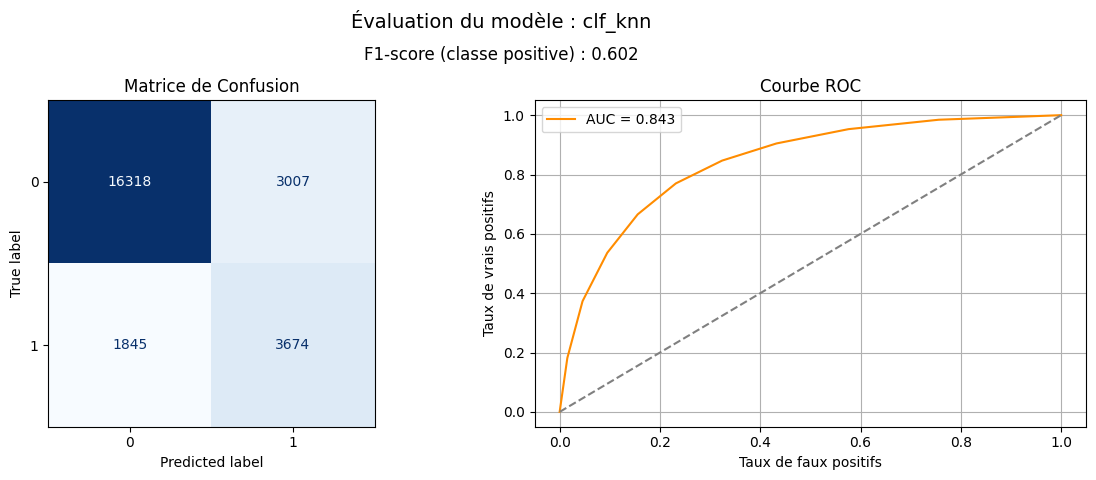

estimateur:{Best params}, scores_f_fold, best_score_f1, Accuracy
{'random_search': ['clf_knn', {'n_neighbors': 9}, array([0.743, 0.755, 0.76 , 0.765]), np.float64(0.765), np.float64(0.805)]}
Seuil optimal : 0.62 | F1 Score : 0.6782

Rapport de classification :
              precision    recall  f1-score   support

           0       0.92      0.87      0.90     19325
           1       0.63      0.74      0.68      5519

    accuracy                           0.84     24844
   macro avg       0.77      0.81      0.79     24844
weighted avg       0.86      0.84      0.85     24844


Rapport de classification :
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.87      0.74      0.90      0.80      0.65     19325
          1       0.63      0.74      0.87      0.68      0.80      0.64      5519

avg / total       0.86      0.84      0.77      0.85      0.80      0.65     24844



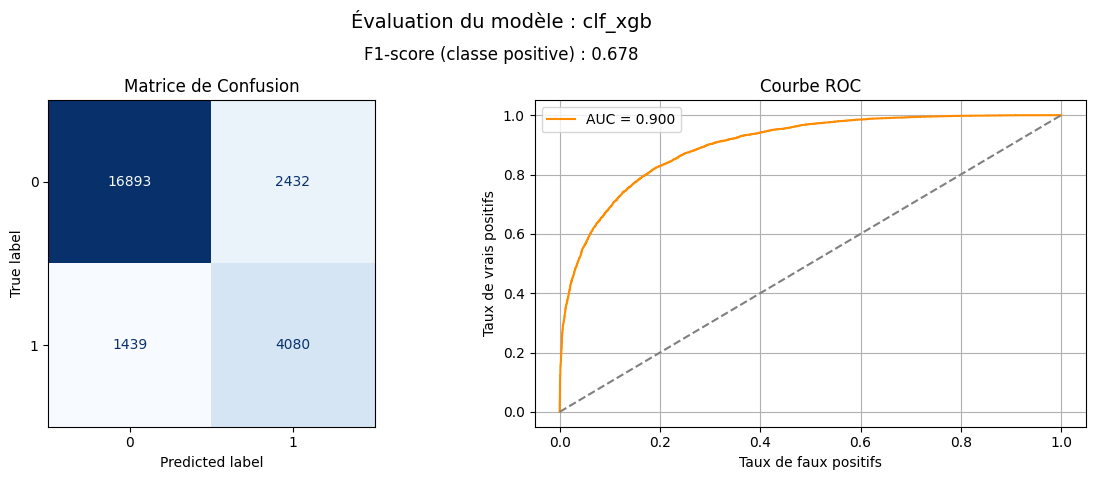

estimateur:{Best params}, scores_f_fold, best_score_f1, Accuracy
{'random_search': ['clf_xgb', {'n_jobs': -2}, array([0.809]), np.float64(0.809), np.float64(0.844)]}


In [ ]:
models = {"clf_lr" : [LogisticRegression(),
                          {'C': [0.1, 1, 10, 100, 1000], 'solver': ["liblinear","newton-cholesky"], "class_weight":["balanced"]}],#solver de classification binaire
          "clf_rf" : [RandomForestClassifier(),
                     {'n_estimators': [25, 50, 100,150, 175, 200, 250, 300, 400], "class_weight":["balanced",None], "n_jobs":[-2]}],
         "clf_xgb" : [xgb.XGBClassifier()]}

results = {}

def compare_search_methods_bayes(model_name, model, param_grid, X_train, X_test, y_train, y_test):

    bayes = BayesSearchCV(estimator = model, search_spaces = param_grid,
                                              n_iter = 5, random_state = 42, cv=skf, n_jobs = -2, scoring = "f1")
    bayes.fit(X_train, y_train) #Suite à l’entrainement, la meilleure combinaison et son score ont été trouvé
    results["Bayes"] = [model_name, bayes.best_params_, 
                        np.round(bayes.cv_results_["mean_test_score"],3), 
                        np.round(bayes.best_score_,3)]
    #y_pred = bayes.predict(X_test) #sera lancé sur le meilleur param
    y_pred, y_proba = predictions_seuil_optimal(bayes, X_test, y_test) #Fonction qui cherche le seuil d'appartenance optimale
    accuracy = np.round(accuracy_score(y_test, y_pred),3) # comme bcp de metrics besoin prévision sur data jamais vues pour évaluer
    results["Bayes"].append(accuracy)
    evaluation(model_name,y_test, y_pred, y_proba) #Fonction présentant les résultats
    return results

skf = StratifiedKFold(n_splits=5, random_state=111, shuffle=True) 

for classifier_name, detail_classifier in models.items() :
    results = compare_search_methods_bayes(classifier_name, detail_classifier[0], detail_classifier[1], X_train_resampling, X_test, y_train_resampling, y_test)
    print("estimateur:{Best params}, scores_f_fold, best_score_f1, Accuracy")
    print(results)

In [52]:
# Importance des features
importances = search.best_estimator_.feature_importances_
features = X_train_sample.columns

# DataFrame trié
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Affichage du top des features
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Importance des variables (XGBoost)")
plt.xlabel("Score d'importance")
plt.tight_layout()
plt.show()


NameError: name 'search' is not defined

In [53]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, Flatten, RepeatVector, LSTM, Bidirectional,
    GRU, concatenate, Dense)



X_train=pd.read_csv("X_train_scaled.csv") 
X_test=pd.read_csv("X_test_scaled.csv") 

y_train=pd.read_csv("y_train.csv") 
y_test=pd.read_csv("y_test.csv") 

#1 ARCHITECTURE
# Reshape en 3D pour Conv1D : (n_samples, time_steps=nb_features, 1)
n_samples, n_features = X_scaled.shape #sur X_rain ou sur X_test?
X_3d = X_scaled.reshape((n_samples, n_features, 1))  # :contentReference[oaicite:8]{index=8}

# Entrée 3D
inputs = Input(shape=(n_features, 1), name='input_layer')

# Extraction locale par convolution
conv = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
flat = Flatten()(conv)  # :contentReference[oaicite:9]{index=9}

# Reshape pour RNN: on passe du vecteur flatten à une séquence d’une étape
seq = RepeatVector(1)(flat)

# Branche LSTM
lstm_out = LSTM(32)(seq)  # :contentReference[oaicite:10]{index=10}

# Branche BiLSTM
bilstm_out = Bidirectional(LSTM(32, return_sequences=False))(seq)  # :contentReference[oaicite:11]{index=11}

# Branche GRU
gru_out = GRU(32)(seq)  # :contentReference[oaicite:12]{index=12}

# Concatenation des trois branches
merged = concatenate([lstm_out, bilstm_out, gru_out])

# Couche de sortie binaire
output = Dense(1, activation='sigmoid', name='output_layer')(merged)

# Modèle final
model = Model(inputs=inputs, outputs=output, name='MeteroNet')



ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
#shap
clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train, y_train)

# Calcul d'un résumé de X_train avec shap.kmeans 
X_train_summary_dense = shap.kmeans(X_train.values, 10)
X_train_summary_array = X_train_summary_dense.data
X_train_summary = pd.DataFrame(X_train_summary_array, columns=X_train.columns)

# Envelopper la fonction de prédiction pour recréer un DataFrame
predict_fn = lambda x: clf_xgb.predict(pd.DataFrame(x, columns=X_train.columns))

# Création de l'explainer SHAP avec la fonction enveloppée
explainer = shap.KernelExplainer(predict_fn, X_train_summary)

# Calcul des valeurs SHAP sur X_test
shap_values = explainer.shap_values(X_test)

# Affichage du summary plot
shap.initjs()
shap.summary_plot(shap_values, X_test)


In [ ]:
clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train, y_train)

# Utiliser TreeExplainer pour les modèles d'arbres
explainer = shap.TreeExplainer(clf_xgb)
shap_values = explainer.shap_values(X_test)

shap.initjs()
shap.summary_plot(shap_values, X_test)

In [ ]:
i=1 #ligne d'observation
shap.waterfall_plot(shap.Explanation(values=shap_values[i], 
                                       base_values=explainer.expected_value, 
                                       data=X_test.iloc[i]))


In [ ]:
#Selctionner que 100 lignes au hasard?
shap.decision_plot(explainer.expected_value, shap_values, X_test)


In [ ]:
shap.dependence_plot("Cloud9am", shap_values, X_test)
